In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.autograd import Variable
from tqdm import tqdm
import pandas as pd

from torchsummary import summary


# Analyse training

In [82]:
df = pd.read_csv('res50_smallMLP_200epochs_lr0dot001_reduceLRplateau/train_loss_tab.csv')

In [83]:
best_epoch = df['val_loss'].argmin()+1
floor_best_epoch = 10 * (best_epoch//10)
ceil_best_epoch = 10 * (best_epoch//10 + 1)
print(f"{best_epoch = }, {floor_best_epoch = }")

best_epoch = 13, floor_best_epoch = 10


In [84]:
print(df['val_loss'][best_epoch-1])
print(df['val_loss'][floor_best_epoch-1])
print(df['val_loss'][ceil_best_epoch-1])
print(df['val_acc'][best_epoch-1])
print(df['val_acc'][floor_best_epoch-1])
print(df['val_acc'][ceil_best_epoch-1])

0.0157322796803076
0.0162582987720526
0.0183112262522132
70.87378692626953
70.87378692626953
68.93203735351562


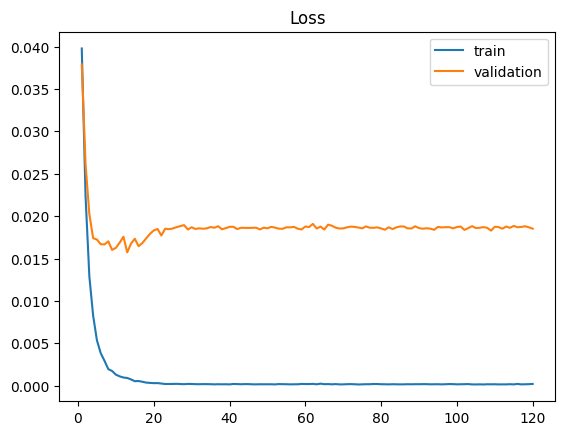

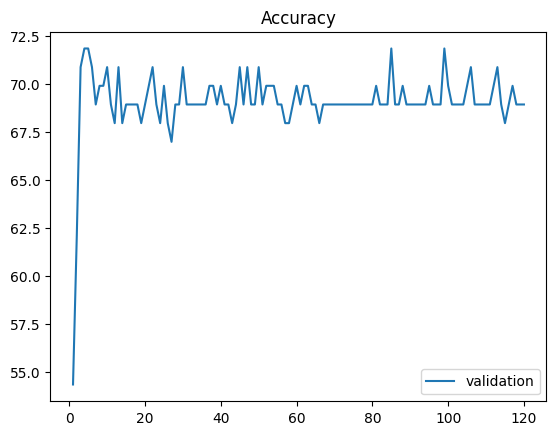

In [85]:
if True:
    plt.plot(df['epoch'],df['train_loss'],label='train')
    plt.plot(df['epoch'],df['val_loss'],label='validation')
    plt.legend()
    plt.title('Loss')
    plt.show()

    plt.plot(df['epoch'],df['val_acc'],label='validation')
    plt.legend()
    plt.title("Accuracy")
    plt.show()

# Test

In [36]:
nclasses = 20
class EndModel(nn.Module):

    def __init__(self,in_features,out_features):
        super(EndModel,self).__init__()
        self.fc1 = nn.Linear(in_features, out_features)
        #self.fc2 = nn.Linear(256, out_features)

        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        return x
        #return self.fc2(x)


class Net(nn.Module):

    def __init__(self,nclasses):
        super(Net,self).__init__()

        self.resnet = torchvision.models.resnet50(weights="ResNet50_Weights.IMAGENET1K_V2")
        self.num_ftrs = self.resnet.fc.out_features
        self.endmodel = EndModel(self.num_ftrs,nclasses)

        # freeze the resnet layers
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self,x):
        x = self.resnet(x)
        return x

In [37]:
endmodel = EndModel(1000,20).to("cuda")
summary(endmodel,(1,1000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 20]          20,020
Total params: 20,020
Trainable params: 20,020
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


In [20]:
model = Net(20).to("cuda")

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
from torchvision import transforms
data_transforms = transforms.Compose([
    transforms.Resize((232, 232)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

#data_transforms = torchvision.models.ResNet50_Weights.IMAGENET1K_V2.transforms

In [31]:
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('bird_dataset' + '/train_images',
                         transform=data_transforms),
    batch_size=64, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('bird_dataset' + '/val_images',
                         transform=data_transforms),
    batch_size=64, shuffle=False, num_workers=0)


In [32]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if True:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 2 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
    return loss.data.item()

In [60]:
model = Net(20)
model.load_state_dict(torch.load('experiment/model_1.pth'))

<All keys matched successfully>

In [61]:
# Check that the frozen layers weren't trained
res = torchvision.models.resnet50(weights="ResNet50_Weights.IMAGENET1K_V2")
a = model.resnet.layer4[0].conv2.weight
b = res.layer4[0].conv2.weight

In [ ]:
a-b